<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [42]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [43]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [44]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

### Preferential Attachment with followers and followees data of vertex

In [45]:
if os.path.isfile('data/after_eda/train_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))

DiGraph with 1862196 nodes and 15100030 edges


In [46]:
if os.path.isfile('data/after_eda/test_after_eda.csv'):
    test_graph=nx.read_edgelist('data/after_eda/test_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(test_graph))

DiGraph with 1767753 nodes and 3775008 edges


In [47]:
def preferantial_attachment_followers(s,d):
    if len(set(train_graph.predecessors(s))) == 0  | len(set(train_graph.predecessors(d))) == 0:
            return 0
    ps=len(set(train_graph.predecessors(s)))
    pd=len(set(train_graph.predecessors(d)))
    score=ps*pd
    return score

def preferantial_attachment_followees(s,d):
    if len(set(train_graph.successors(s))) == 0  | len(set(train_graph.successors(d))) == 0:
            return 0
    ps=len(set(train_graph.successors(s)))
    pd=len(set(train_graph.successors(d)))
    score=ps*pd
    return score

def preferantial_attachment_followers_t(s,d):
    if len(set(test_graph.predecessors(s))) == 0  | len(set(test_graph.predecessors(d))) == 0:
            return 0
    ps=len(set(test_graph.predecessors(s)))
    pd=len(set(test_graph.predecessors(d)))
    score=ps*pd
    return score

def preferantial_attachment_followees_t(s,d):
    if len(set(test_graph.successors(s))) == 0  | len(set(test_graph.successors(d))) == 0:
            return 0
    ps=len(set(test_graph.successors(s)))
    pd=len(set(test_graph.successors(d)))
    score=ps*pd
    return score

### Final Dataset

In [49]:
df_final_train['pa_followers'] = df_final_train.apply(lambda row: preferantial_attachment_followers(row['source_node'],row['destination_node']),axis=1)

In [50]:
df_final_train['pa_followees'] = df_final_train.apply(lambda row: preferantial_attachment_followees(row['source_node'],row['destination_node']),axis=1)

In [51]:
df_final_test['pa_followers'] = df_final_test.apply(lambda row: preferantial_attachment_followers_t(row['source_node'],row['destination_node']),axis=1)
df_final_test['pa_followees'] = df_final_test.apply(lambda row: preferantial_attachment_followees_t(row['source_node'],row['destination_node']),axis=1)

In [52]:
x1 = list(df_final_train['svd_u_s_1'])
x2 = list(df_final_train['svd_u_s_2'])
x3 = list(df_final_train['svd_u_s_3'])
x4 = list(df_final_train['svd_u_s_4'])
x5 = list(df_final_train['svd_u_s_5'])
x6 = list(df_final_train['svd_u_s_6'])

x7 = list(df_final_train['svd_u_d_1'])
x8 = list(df_final_train['svd_u_d_2'])
x9 = list(df_final_train['svd_u_d_3'])
x10 = list(df_final_train['svd_u_d_4'])
x11 = list(df_final_train['svd_u_d_5'])
x12 = list(df_final_train['svd_u_d_6'])

y1 = list(df_final_train['svd_v_s_1'])
y2 = list(df_final_train['svd_v_s_2'])
y3 = list(df_final_train['svd_v_s_3'])
y4 = list(df_final_train['svd_v_s_4'])
y5 = list(df_final_train['svd_v_s_5'])
y6 = list(df_final_train['svd_v_s_6'])

y7 = list(df_final_train['svd_v_d_1'])
y8 = list(df_final_train['svd_v_d_2'])
y9 = list(df_final_train['svd_v_d_3'])
y10 = list(df_final_train['svd_v_d_4'])
y11 = list(df_final_train['svd_v_d_5'])
y12 = list(df_final_train['svd_v_d_6'])

train_u_source = []
train_u_destination = []
train_v_source = []
train_v_destination = []
train_u_s_dot = []
train_u_d_dot = []

for loop1 in range(0,len(x1)):
    train_u_source.append(x1[loop1])                             
    train_u_source.append(x2[loop1])
    train_u_source.append(x3[loop1])
    train_u_source.append(x4[loop1])
    train_u_source.append(x5[loop1])
    train_u_source.append(x6[loop1])

    train_u_destination.append(x7[loop1]) 
    train_u_destination.append(x8[loop1])
    train_u_destination.append(x9[loop1])
    train_u_destination.append(x10[loop1])
    train_u_destination.append(x11[loop1])
    train_u_destination.append(x12[loop1])

    dot_product = np.dot(train_u_source[loop1],train_u_destination[loop1])
    train_u_s_dot.append(dot_product)

    
for loop2 in range(0,len(y1)):   
    train_v_source.append(y1[loop2]) 
    train_v_source.append(y2[loop2])
    train_v_source.append(y3[loop2])
    train_v_source.append(y4[loop2])
    train_v_source.append(y5[loop2])
    train_v_source.append(y6[loop2])

    train_v_destination.append(y7[loop2]) 
    train_v_destination.append(y8[loop2])
    train_v_destination.append(y9[loop2])
    train_v_destination.append(y10[loop2])
    train_v_destination.append(y11[loop2])
    train_v_destination.append(y12[loop2])

    dot_product = np.dot(train_v_source[loop2],train_v_destination[loop2])
    train_u_d_dot.append(dot_product)
    
print("*******************************************")
print(np.shape(train_u_s_dot))
print(np.shape(train_u_d_dot))

*******************************************
(100002,)
(100002,)


In [53]:
# for Test data

x1 = list(df_final_test['svd_u_s_1'])
x2 = list(df_final_test['svd_u_s_2'])
x3 = list(df_final_test['svd_u_s_3'])
x4 = list(df_final_test['svd_u_s_4'])
x5 = list(df_final_test['svd_u_s_5'])
x6 = list(df_final_test['svd_u_s_6'])

x7 = list(df_final_test['svd_u_d_1'])
x8 = list(df_final_test['svd_u_d_2'])
x9 = list(df_final_test['svd_u_d_3'])
x10 = list(df_final_test['svd_u_d_4'])
x11 = list(df_final_test['svd_u_d_5'])
x12 = list(df_final_test['svd_u_d_6'])

y1 = list(df_final_test['svd_v_s_1'])
y2 = list(df_final_test['svd_v_s_2'])
y3 = list(df_final_test['svd_v_s_3'])
y4 = list(df_final_test['svd_v_s_4'])
y5 = list(df_final_test['svd_v_s_5'])
y6 = list(df_final_test['svd_v_s_6'])

y7 = list(df_final_test['svd_v_d_1'])
y8 = list(df_final_test['svd_v_d_2'])
y9 = list(df_final_test['svd_v_d_3'])
y10 = list(df_final_test['svd_v_d_4'])
y11 = list(df_final_test['svd_v_d_5'])
y12 = list(df_final_test['svd_v_d_6'])

test_u_source = []
test_u_destination = []
test_v_source = []
test_v_destination = []
test_v_s_dot = []
test_v_d_dot = []

for loop3 in range(0,len(x1)):
    test_u_source.append(x1[loop3])                              
    test_u_source.append(x2[loop3])
    test_u_source.append(x3[loop3])
    test_u_source.append(x4[loop3])
    test_u_source.append(x5[loop3])
    test_u_source.append(x6[loop3])

    test_u_destination.append(x7[loop3])
    test_u_destination.append(x8[loop3])
    test_u_destination.append(x9[loop3])
    test_u_destination.append(x10[loop3])
    test_u_destination.append(x11[loop3])
    test_u_destination.append(x12[loop3])
    
    dot_product = np.dot(test_u_source[loop3],test_u_destination[loop3])
    test_v_s_dot.append(dot_product)

for loop4 in range(0,len(y1)):
    test_v_source.append(y1[loop4])
    test_v_source.append(y2[loop4])
    test_v_source.append(y3[loop4])
    test_v_source.append(y4[loop4])
    test_v_source.append(y5[loop4])
    test_v_source.append(y6[loop4])

    test_v_destination.append(y7[loop4])
    test_v_destination.append(y8[loop4])
    test_v_destination.append(y9[loop4])
    test_v_destination.append(y10[loop4])
    test_v_destination.append(y11[loop4])
    test_v_destination.append(y12[loop4])
    dot_product = np.dot(test_v_source[loop4],test_v_destination[loop4])
    test_v_d_dot.append(dot_product)

print("*******************************************")
print(np.shape(test_v_s_dot))
print(np.shape(test_v_d_dot))

*******************************************
(50002,)
(50002,)


In [54]:
startTime = datetime.datetime.now()
print("Current Time = ",startTime)

if not os.path.isfile('data/fea_sample/storage_sample_stage6.h5'):
    #===================================================================================================
    df_final_train['s_dot'] = np.array(train_u_s_dot)
    df_final_train['d_dot'] = np.array(train_u_d_dot)
    
    df_final_test['s_dot'] = np.array(test_v_s_dot)
    df_final_test['d_dot'] = np.array(test_v_d_dot)

    hdf = HDFStore('data/fea_sample/storage_sample_stage6.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'test_df',mode='r')
    
print("Time taken for creation of dataframe is {}".format(datetime.datetime.now() - startTime))

Current Time =  2022-02-18 17:18:01.175500
Time taken for creation of dataframe is 0:00:03.959332


In [55]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage6.h5', 'test_df',mode='r')

In [56]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pa_followers', 'pa_followees', 's_dot', 'd_dot'],
      dtype='object')

In [57]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pa_followers', 'pa_followees', 's_dot', 'd_dot'],
      dtype='object')

In [58]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [59]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [60]:
df_final_train.shape

(100002, 55)

In [61]:
df_final_test.shape

(50002, 55)

In [62]:
y_train.shape

(100002,)

In [63]:
y_test.shape

(50002,)

Estimators =  10 Train Score 0.9219834258216011 test Score 0.8984438984438985
Estimators =  50 Train Score 0.9206461698801459 test Score 0.9099387439326819
Estimators =  100 Train Score 0.921223277412877 test Score 0.9176783004552352
Estimators =  250 Train Score 0.9212977498691785 test Score 0.9176004718173393
Estimators =  450 Train Score 0.9221144692380923 test Score 0.9184795198483732


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

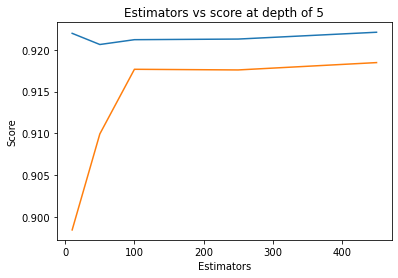

In [64]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9113669987688424 test Score 0.8998550450620785
depth =  9 Train Score 0.9582165890635665 test Score 0.9228801476138556
depth =  11 Train Score 0.9600911968569654 test Score 0.9236540436322486
depth =  15 Train Score 0.9643447653246503 test Score 0.9240714866640253
depth =  20 Train Score 0.9642220060001621 test Score 0.9247608305134312
depth =  35 Train Score 0.9646188158961881 test Score 0.9252004677581023
depth =  50 Train Score 0.9646188158961881 test Score 0.9252004677581023
depth =  70 Train Score 0.9646188158961881 test Score 0.9252004677581023
depth =  130 Train Score 0.9646188158961881 test Score 0.9252004677581023


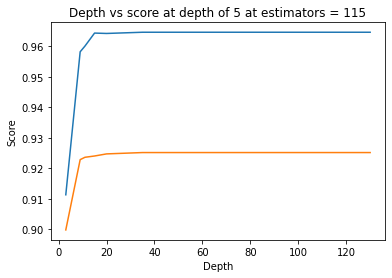

In [65]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [67]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96276917 0.96220101 0.96103101 0.96261687 0.96358805]
mean train scores [0.96379017 0.96280752 0.96131401 0.96314388 0.96479838]


In [68]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [69]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [70]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [71]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9647113716818647
Test f1 score 0.9259692513368983


In [72]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


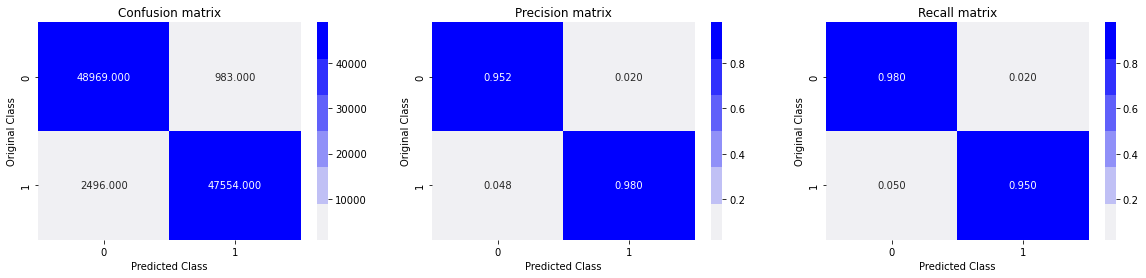

Test confusion_matrix


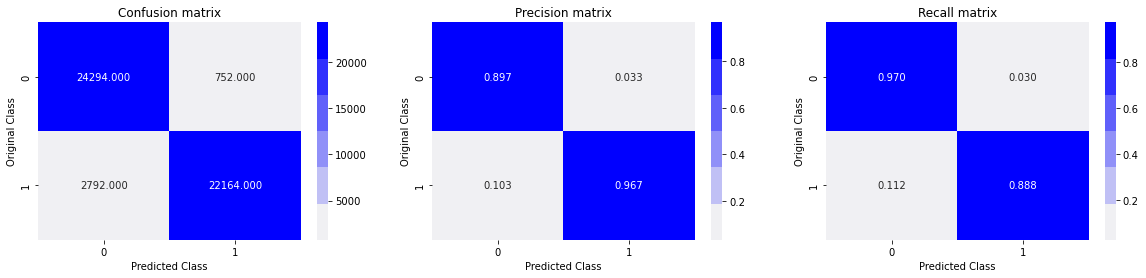

In [73]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

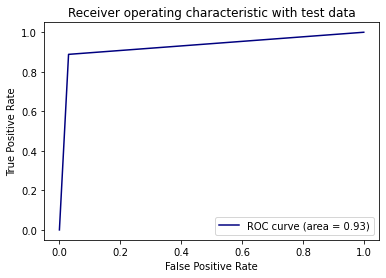

In [74]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

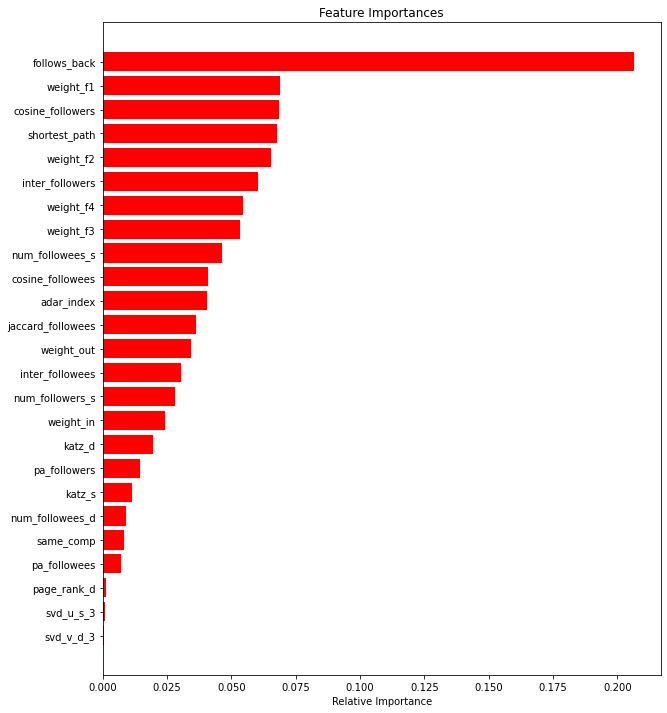

In [75]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

In [81]:
startTime = datetime.datetime.now()
print("Current Time = ",startTime)

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score,make_scorer

min_child_weight = [2,4,6]
max_depth = [2,4,6]
n_estimators =[100,200,300]
learning_rate = [0.1,0.2,0.3]

scorer = make_scorer(f1_score)
tuned_parameters = {
                    'min_child_weight':min_child_weight,
                    'max_depth':max_depth,
                    'n_estimators': n_estimators,
                    'learning_rate':learning_rate}

clf = xgb.XGBClassifier(eval_metric='auc')
model_gbt = RandomizedSearchCV(clf,tuned_parameters,scoring =scorer,cv=3,pre_dispatch=2)
model_gbt.fit(df_final_train,y_train)
print(model_gbt.best_estimator_)

best_min_child_weight_xgb = model_gbt.best_estimator_.min_child_weight
best_max_depth_xgb = model_gbt.best_params_["max_depth"]
best_n_estimators_xgb = model_gbt.best_estimator_.n_estimators
best_learning_rate_xgb = model_gbt.best_estimator_.learning_rate

print("\nbest_min_child_weight_xgb = ", best_min_child_weight_xgb)
print("best_max_depth_xgb = ",best_max_depth_xgb)
print("best_n_estimators_xgb = ", best_n_estimators_xgb)
print("best_learning_rate_xgb = ",best_learning_rate_xgb)

print("Time taken for creation of dataframe is {}".format(datetime.datetime.now() - startTime))

Current Time =  2022-02-18 17:55:45.723460
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=4, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

best_min_child_weight_xgb =  2
best_max_depth_xgb =  4
best_n_estimators_xgb =  200
best_learning_rate_xgb =  0.3
Time taken for creation of dataframe is 0:03:13.417151


In [83]:
startTime = datetime.datetime.now()
print("Current Time = ",startTime)

xgb_best = xgb.XGBClassifier(objective='binary:logistic',learning_rate = best_learning_rate_xgb,
                             min_child_weight = best_min_child_weight_xgb,n_estimators = best_n_estimators_xgb,
                             max_depth = best_max_depth_xgb,eval_metric='auc')
xgb_best.fit(df_final_train,y_train)
pred_train = xgb_best.predict(df_final_train)
pred_test = xgb_best.predict(df_final_test)

train_score = f1_score(y_train,pred_train)
test_score = f1_score(y_test,pred_test)
print('\nTrain Score: ',train_score)
print('Test Score: ',test_score)

print("Time taken for creation of dataframe is {}".format(datetime.datetime.now() - startTime))

Current Time =  2022-02-18 18:00:21.072634

Train Score:  0.992777070957013
Test Score:  0.9086790256879208
Time taken for creation of dataframe is 0:00:10.899981


Train confusion_matrix


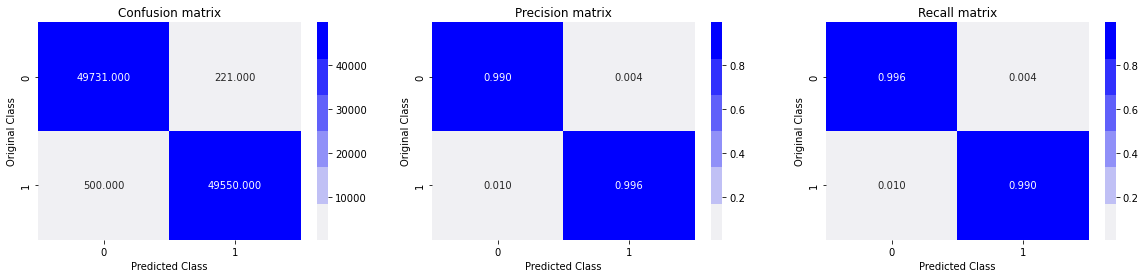

Test confusion_matrix


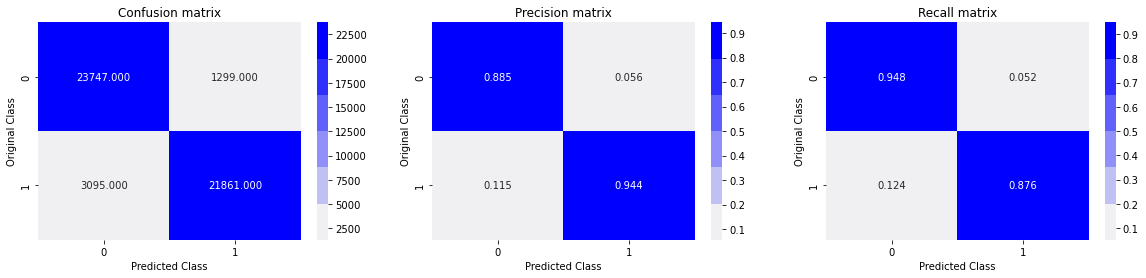

In [84]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,pred_train)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,pred_test)

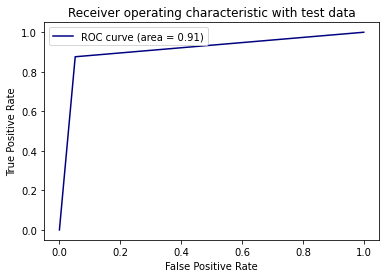

In [85]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,pred_test)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

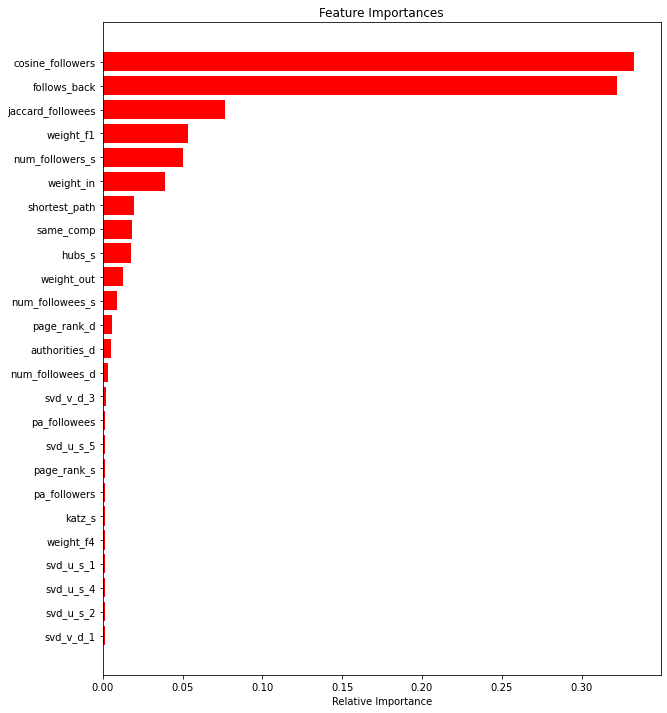

In [86]:
features = df_final_train.columns
importances = xgb_best.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [88]:
pip install prettytable

Note: you may need to restart the kernel to use updated packages.


In [89]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model \ Parameters","Train f1_score","Test f1_score"]
x.add_row(["RandomForest: ",0.9647113716818647,0.9259692513368983])
x.add_row(["XGBClassifier: ",0.992777070957013,0.9086790256879208])
print(x)

+--------------------+--------------------+--------------------+
| Model \ Parameters |   Train f1_score   |   Test f1_score    |
+--------------------+--------------------+--------------------+
|   RandomForest:    | 0.9647113716818647 | 0.9259692513368983 |
|  XGBClassifier:    | 0.992777070957013  | 0.9086790256879208 |
+--------------------+--------------------+--------------------+
